# G.4 - Additional Measures and Investigations Concerning Clusters

This notebooks contains further investigation into clusters, including deeper examination of those clusters used in the clustering section of the paper, as well as other cluster related measures applied to our network, which are not used in the main paper.

In [1]:
# import relevant packages
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import requests as rq
import pickle
import igraph as ig
import leidenalg
from networkx.algorithms.community import louvain_communities
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

As a basis, we will have the network including all available attributes.

In [2]:
url = "https://raw.githubusercontent.com/nicosrp/The-Architecture-of-Aspiration-A-Network-Perspective-on-Human-Goals/main/Networks/dayzero_network.pkl"
response = rq.get(url)
G = pickle.loads(response.content)

print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Network loaded: 2890 nodes, 219130 edges


In [3]:
attr_keys = {k for _, attrs in G.nodes(data=True) for k in attrs}
print(sorted(attr_keys))

['category', 'city', 'comments', 'country', 'description', 'have_done', 'included_by_our_users', 'other_map_location', 'tags', 'title', 'wants_to_do']


### Exploring Sentiment per Category

#### Preparation of the Sentiment Scores

To explore the sentiment of each category, we will be using the LabMT sentiment scores. Therefore, we first need to import the relevant file.

In [4]:
labmt_path = "../Data/Additional Data/labmt.txt"

labmt_in = pd.read_csv(labmt_path, sep=r"\s+", engine="python", skiprows=2)
labmt = dict(zip(labmt_in["word"], labmt_in["happiness_average"]))

print(f"LabMT lexicon loaded: {len(labmt)} words")

LabMT lexicon loaded: 10222 words


Next, we need to pre-process our goals' titles and descriptions.

In [5]:
stop_words = set(stopwords.words("english"))

# Get both title and description
goal_titles = nx.get_node_attributes(G, "title")
goal_descriptions = nx.get_node_attributes(G, "description")

# Combine title and description for full text
goal_full_text = {}
for goal in G.nodes():
    title = goal_titles.get(goal, "")
    description = goal_descriptions.get(goal, "")
    # Combine with space separator
    combined = f"{title} {description}".strip()
    goal_full_text[goal] = combined if combined else None

# For LabMT: tokenize and clean (removes stopwords, punctuation)
goal_tokens = {}
for goal, text in goal_full_text.items():
    if text:
        tokens = word_tokenize(text)
        tokens = [t.lower() for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in stop_words]
        goal_tokens[goal] = tokens

print(f"Combined title + description for {len(goal_full_text)} goals")
print(f"Tokenized {len([g for g, t in goal_tokens.items() if t])} goals with content")

Combined title + description for 2890 goals
Tokenized 2890 goals with content


Then, we define a function to calculate the sentiment of a document based on the LabMT scores.

In [6]:
def calculate_labmt_sentiment(tokens, labmt):
    scores = []
    for token in tokens:
        if token in labmt:
            scores.append(labmt[token])
    
    if not scores:
        return None 
    
    return sum(scores) / len(scores)

Now we can assign a sentiment score to each goal, and assign the score back to the network as a node attribute.

In [7]:
labmt_results = {}

for goal, tokens in goal_tokens.items():
    scores = [labmt[token] for token in tokens if token in labmt]
    labmt_results[goal] = sum(scores) / len(scores) if scores else None

nx.set_node_attributes(G, labmt_results, name="labmt_sentiment")
print(f"LabMT sentiment calculated for {len([v for v in labmt_results.values() if v is not None])} goals")

LabMT sentiment calculated for 2890 goals


In [8]:
attr_keys = {k for _, attrs in G.nodes(data=True) for k in attrs}
print(sorted(attr_keys))

['category', 'city', 'comments', 'country', 'description', 'have_done', 'included_by_our_users', 'labmt_sentiment', 'other_map_location', 'tags', 'title', 'wants_to_do']


#### Preparation of the Categories

As our categories, created in notebook 8.1 are not imported in the network used here, we need to create them again, following the same steps as before, including the fix for the classification of one of the nodes.

In [9]:
# using only the giant connected component

components = list(nx.connected_components(G))
largest_cc = max(components, key=len)
Gcc = G.subgraph(largest_cc).copy()

In [10]:
# fix category for read lolita
Gcc.nodes['Csz8rzLw']['category'] = "Media consumption" 
Gcc.nodes['Csz8rzLw']['location'] = "No location mentioned"  

In [11]:
# Suppose Gcc is your giant connected component
category_comms = defaultdict(list)
for node, data in Gcc.nodes(data=True):
    cat = data.get("category")
    category_comms[cat].append(node)

# Convert to list of sets for modularity calculations
category_comms_sets = [set(nodes) for nodes in category_comms.values()]

#### Exploring the Sentiment per Category

With all preparations done, we can now explore the sentiment of each categorz. For this, we simply calculate the average sentiment value for all items within a category.

In [12]:
category_values = defaultdict(list)

for _, data in Gcc.nodes(data=True):
    cat = data.get("category")
    sent = data.get("labmt_sentiment")
    if cat is not None and sent is not None:
        category_values[cat].append(sent)

avg_sentiment_category = {
    cat: np.mean(vals) for cat, vals in category_values.items()
}

In [13]:
for cat, score in sorted(avg_sentiment_category.items(), key=lambda x: x[1]):
    print(f"{cat}: {score:.3f}")

Sports: 5.788
Health: 5.788
Academic and professional achievements: 5.832
Religion: 5.847
New skills: 5.850
Experiences: 5.863
Places of interest: 5.888
Creativity: 5.940
Travel destinations: 5.951
Acts of kindness/altruism: 5.975
Nature: 5.977
Media consumption: 5.990
Food: 6.002
Events & concerts: 6.045
Relationships & social life: 6.091


As we can see, sports and health have the lowest average sentiment scores, while relationships and events have the highest. The difference, however, is not very large at around only 0.3.

### Exploring Sentiment per Structural Community

Aside from the sentiment per category, we also investigated the sentiment per structural community.

#### Preparation of the Communities

Again, we need to recreate the communites created in notebook 8.1.

In [14]:
# Convert NetworkX → igraph
ig_graph = ig.Graph.from_networkx(Gcc)

# Ensure the node name attribute exists
ig_graph.vs["name"] = list(Gcc.nodes())

# Run Leiden
partition_leiden = leidenalg.find_partition(
    ig_graph,
    leidenalg.ModularityVertexPartition,
    weights="weight",
    seed=42    # ensures deterministic output
)

# Assign Leiden community back to NetworkX
for node, comm in zip(ig_graph.vs["name"], partition_leiden.membership):
    Gcc.nodes[node]["leiden_community"] = comm

#### Exploring the Sentiment per Community

In [15]:
community_values = defaultdict(list)

for _, data in Gcc.nodes(data=True):
    com = data.get("leiden_community")
    sent = data.get("labmt_sentiment")
    if com is not None and sent is not None:
        community_values[com].append(sent)

avg_sentiment_community = {
    com: np.mean(vals) for com, vals in community_values.items()
}

In [16]:
for cat, score in sorted(avg_sentiment_community.items(), key=lambda x: x[1]):
    print(f"{cat}: {score:.3f}")

6: 5.784
4: 5.904
2: 5.924
0: 5.925
7: 5.927
5: 5.928
1: 5.946
3: 5.963


As we can see above, the sentiment of the different communities is highly similar and in fact much more homogeneous than when looking at the sentiment of categories.

### Exploring Percentage of Location Based Goals per Structural Community

While in notebook 8.1 we explored the differences in what percentage of goals contained in each category references a location. In this notebook, we present the same analysis but looking at structurcal communities rather than categories.

In [17]:
location_attrs = ['country', 'city', 'other_map_location']

# Collect a binary indicator for location per category
community_location = defaultdict(list)

for _, data in Gcc.nodes(data=True):
    cat = data.get("leiden_community")
    if cat is not None:
        # 1 if any location attribute is assigned, 0 otherwise
        has_location = int(any(data.get(attr) not in [None, 'None'] for attr in location_attrs))
        community_location[cat].append(has_location)

# Compute percentage of nodes with a location per category
percent_location_community = {
    cat: np.mean(vals) * 100 for cat, vals in community_location.items()
}

In [18]:
for cat, score in sorted(percent_location_community.items(), key=lambda x: x[1]):
    print(f"{cat}: {score:.2f}")

0: 64.61
6: 80.00
2: 95.29
5: 95.31
4: 96.38
1: 96.60
3: 97.02
7: 100.00


As we can see, the percentages of how many goals in each structural community are location based varies quite a bit, with one community even containing 100% location based goals.

### Louvain Communities

In addition to the Leiden communities included in the paper, we also computed communities based on the Louvain community detection algorithm.

In [19]:
# set a random seed to get reproducible results
louvain_comms = louvain_communities(Gcc, seed=42)

partition_louvain = {}
for cid, nodes in enumerate(louvain_comms):
    for node in nodes:
        partition_louvain[node] = cid

# Assign to NetworkX
nx.set_node_attributes(Gcc, partition_louvain, "louvain_community")

In [20]:
num_comms_louvain = len(louvain_comms)
print("Number of Louvain communities:", num_comms_louvain)

Number of Louvain communities: 7


In [21]:
# List of community sizes
comm_sizes_louvain = [len(c) for c in louvain_comms]
for i, size in enumerate(comm_sizes_louvain):
    print(f"Community {i}: {size} nodes")

Community 0: 698 nodes
Community 1: 901 nodes
Community 2: 45 nodes
Community 3: 447 nodes
Community 4: 79 nodes
Community 5: 685 nodes
Community 6: 5 nodes


There are 7 communities created based on the Louvain algorithm, which is similar to what the Leiden algorithm produced. The sizes vary slightly more than with the Leiden communities.

In [22]:
# Compute modularity
louvain_modularity = nx.algorithms.community.modularity(Gcc, louvain_comms, weight="weight")
print("Louvain modularity:", louvain_modularity)

Louvain modularity: 0.24662939411661508


The Louvain partition reaches a modularity of around 0.25, which is actually slightly higher than the one reached by the Leiden partition.

#### Comparison of Louvain and Leiden Communities

To better be able to compare Louvain and Leiden partition based communities, we created a heatmap comparing the two.

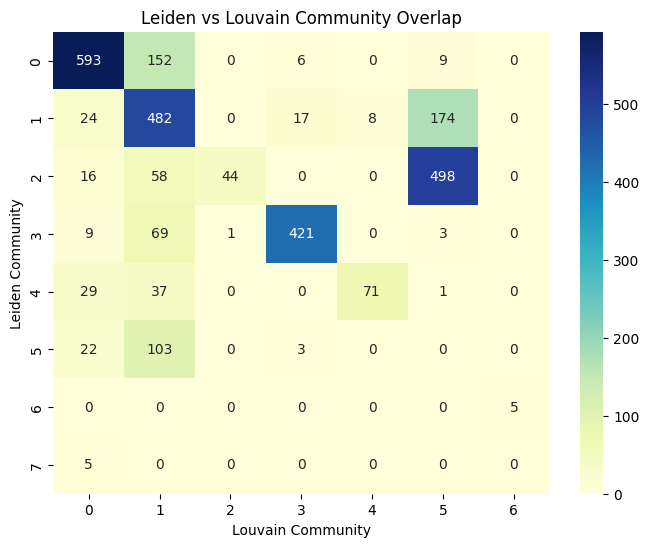

In [23]:
# 'leiden_community' and 'louvain_community'
leiden = nx.get_node_attributes(Gcc, "leiden_community")
louvain = nx.get_node_attributes(Gcc, "louvain_community")

# Make a DataFrame
communties_df = pd.DataFrame({
    "node": list(leiden.keys()),
    "leiden": list(leiden.values()),
    "louvain": [louvain[n] for n in leiden.keys()]
})

# Create a contingency table
heatmap_data = pd.crosstab(communties_df["leiden"], communties_df["louvain"])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Louvain Community")
plt.ylabel("Leiden Community")
plt.title("Leiden vs Louvain Community Overlap")
plt.show()

The heatmap shows that there is significant overlap, though not perfect.

### Deeper Exploration of the Leiden Based Communities

#### Density of Communities

To understand the Leiden based communities better, we explore the density of each community created by the partition.

In [24]:
# List of NetworkX nodes in the same order as igraph vertices
nodes_list = list(Gcc.nodes())

# Map Leiden communities back to NetworkX node IDs
partition_dict = {}
for cid, comm in enumerate(partition_leiden):
    for v in comm:  # v is already an integer index
        partition_dict[nodes_list[v]] = cid

# Now you can iterate over communities
for cid in set(partition_dict.values()):
    nodes = [n for n, c in partition_dict.items() if c == cid]
    subgraph = Gcc.subgraph(nodes)
    density = nx.density(subgraph)
    print(f"Community {cid}: {len(nodes)} nodes, density {density:.2f}")

Community 0: 760 nodes, density 0.09
Community 1: 705 nodes, density 0.07
Community 2: 616 nodes, density 0.16
Community 3: 503 nodes, density 0.24
Community 4: 138 nodes, density 0.16
Community 5: 128 nodes, density 0.19
Community 6: 5 nodes, density 0.60
Community 7: 5 nodes, density 1.00


While most of the bigger communities have a relatively low or moderate density, the two smaller ones have a fairly high one, with community seven being fully connected. Therefore, we will further explore this qualitatively:

In [25]:
target_cid = 7

# Get all nodes in that community
nodes_in_comm = [n for n, c in partition_dict.items() if c == target_cid]

# Display node IDs and their title attributes
for n in nodes_in_comm:
    title = Gcc.nodes[n].get('title', None)  # use None if title is missing
    print(n, title)

cxmhVS2J Visit the Wisconsin Veterans Museum
PquJKMqI Visit the Madison Museum of Contemporary Art
jmdjhzSK Visit the Chazen Museum of Art
mVh7xSVL Visit the UW-Madison Geology Museum
nZdnmhSO Visit the Tommy Bartlett Exploratory


All goals in community seven relate to Wisconsin, and are related to locations in or near Madison.

#### Central Nodes in Communities

Next, we investigated the nodes with the highest degree centrality in each Leiden community.

In [26]:
# Compute degree centrality for all nodes
deg_centrality = nx.degree_centrality(Gcc)

# Collect top nodes per Leiden community
top_nodes_per_comm = defaultdict(list)
for cid in set(partition_dict.values()):
    # Nodes in this community
    nodes_in_comm = [n for n, c in partition_dict.items() if c == cid]
    
    # Sort nodes by degree centrality (descending)
    sorted_nodes = sorted(nodes_in_comm, key=lambda n: deg_centrality[n], reverse=True)
    
    # Pick top 5 nodes
    top_nodes = sorted_nodes[:5]
    
    # Store title and category
    top_nodes_info = [(n, Gcc.nodes[n]['title'], Gcc.nodes[n]['category']) for n in top_nodes]
    
    top_nodes_per_comm[cid] = top_nodes_info

# Display results
for cid, nodes_info in top_nodes_per_comm.items():
    print(f"\nLeiden Community {cid}:")
    for n, title, category in nodes_info:
        print(f" - {title} [{category}]")


Leiden Community 0:
 - See the Northern Lights [Nature]
 - Get a tattoo [Experiences]
 - Visit the Grand Canyon [Travel destinations]
 - Donate blood [Health]
 - Get a massage [Health]

Leiden Community 1:
 - Go to Oktoberfest [Travel destinations]
 - Visit Rome [Travel destinations]
 - Visit Barcelona [Travel destinations]
 - Visit Prague [Travel destinations]
 - Visit Amsterdam [Travel destinations]

Leiden Community 2:
 - Visit the Great Wall of China [Places of interest]
 - Visit the Louvre [Places of interest]
 - Visit Machu Picchu [Travel destinations]
 - Visit the Taj Mahal [Places of interest]
 - Visit Venice [Travel destinations]

Leiden Community 3:
 - Walk across the Golden Gate Bridge [Places of interest]
 - Go to Mardi Gras in New Orleans [Travel destinations]
 - Go to Disneyland [Travel destinations]
 - Tour the White House [Places of interest]
 - Visit New Orleans [Travel destinations]

Leiden Community 4:
 - Visit Alcatraz [Places of interest]
 - Kiss on the top of the

We can see that travel related goals dominate in terms of degree centrality in all communities.

### Exploring Relations Between Categories

To better understand how categories are connected, we created a meta network of categories.

In [27]:
# Create an empty graph for categories
meta_G = nx.Graph()

# Add edges based on inter-category connections
for u, v, data in Gcc.edges(data=True):
    cat_u = Gcc.nodes[u]['category']
    cat_v = Gcc.nodes[v]['category']
    
    if cat_u != cat_v:
        if meta_G.has_edge(cat_u, cat_v):
            meta_G[cat_u][cat_v]['weight'] += data.get('weight', 1)
        else:
            meta_G.add_edge(cat_u, cat_v, weight=data.get('weight', 1))

print("Number of nodes:", meta_G.number_of_nodes())
print("Number of edges:", meta_G.number_of_edges())

Number of nodes: 15
Number of edges: 105


In [28]:
print(nx.density(meta_G))

1.0


The network, consisting of the 15 categories, has 105 edges, which results in a density of 1, meaning the network is fully connected.

### Network Visualization

We attempted to visualize categories and communites in our network. Due to computational limitations, we used a spring layout.

In [29]:
# Map categories to colors
categories = list(set(nx.get_node_attributes(Gcc, 'category').values()))
cat_color_map = {cat: cm.tab20(i / len(categories)) for i, cat in enumerate(categories)}
node_colors_category = [cat_color_map[Gcc.nodes[n]['category']] for n in Gcc.nodes()]

# Map Leiden communities to colors using node attributes
leiden_comms = list(set(nx.get_node_attributes(Gcc, "leiden_community").values()))
leiden_color_map = {comm: cm.tab20(i / len(leiden_comms)) for i, comm in enumerate(leiden_comms)}
node_colors_leiden = [leiden_color_map[Gcc.nodes[n]["leiden_community"]] for n in Gcc.nodes()]

# --- Node sizes ---
node_sizes = [deg * 3 for _, deg in Gcc.degree()]  # same for both plots

In [30]:
# --- Layout (fast) ---
pos = nx.spring_layout(Gcc, iterations=100, seed=42)

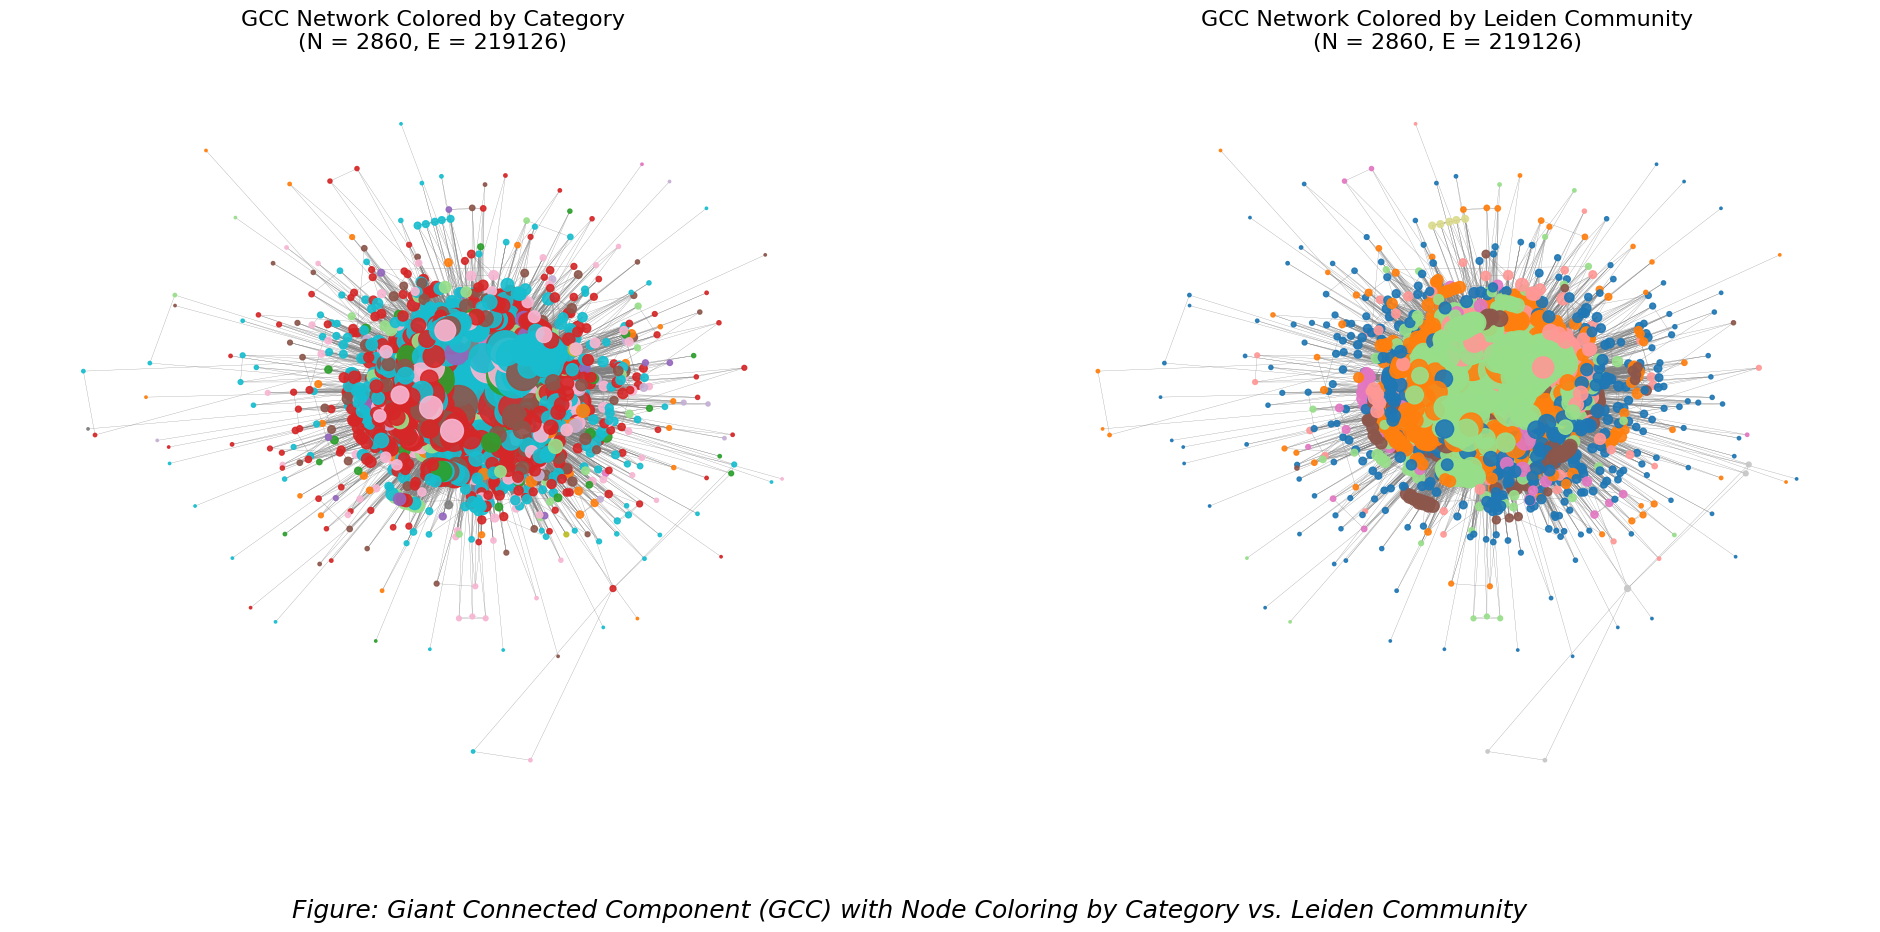

In [31]:
# --- Plot side-by-side ---
plt.figure(figsize=(24, 10))

# Left: Colored by category
plt.subplot(1, 2, 1)
nx.draw(
    Gcc, pos=pos,
    node_size=node_sizes,
    node_color=node_colors_category,
    edge_color='gray',
    with_labels=False,
    width=0.2,
    alpha=0.9
)
plt.title(f"GCC Network Colored by Category\n(N = {Gcc.number_of_nodes()}, E = {Gcc.number_of_edges()})", fontsize=16)

# Right: Colored by Leiden community
plt.subplot(1, 2, 2)
nx.draw(
    Gcc, pos=pos,
    node_size=node_sizes,
    node_color=node_colors_leiden,
    edge_color='gray',
    with_labels=False,
    width=0.2,
    alpha=0.9
)
plt.title(f"GCC Network Colored by Leiden Community\n(N = {Gcc.number_of_nodes()}, E = {Gcc.number_of_edges()})", fontsize=16)

plt.figtext(
    0.5, 0.02,
    "Figure: Giant Connected Component (GCC) with Node Coloring by Category vs. Leiden Community",
    ha="center", fontsize=18, style="italic"
)

plt.show()

We chose not to include this visualization in the paper, as due to the amount of nodes, it is not possible to get much information from the images.

### Wordclouds

As an additional analysis, we created TF-IDF based wordclouds, both for each category and each Leiden partition based community.

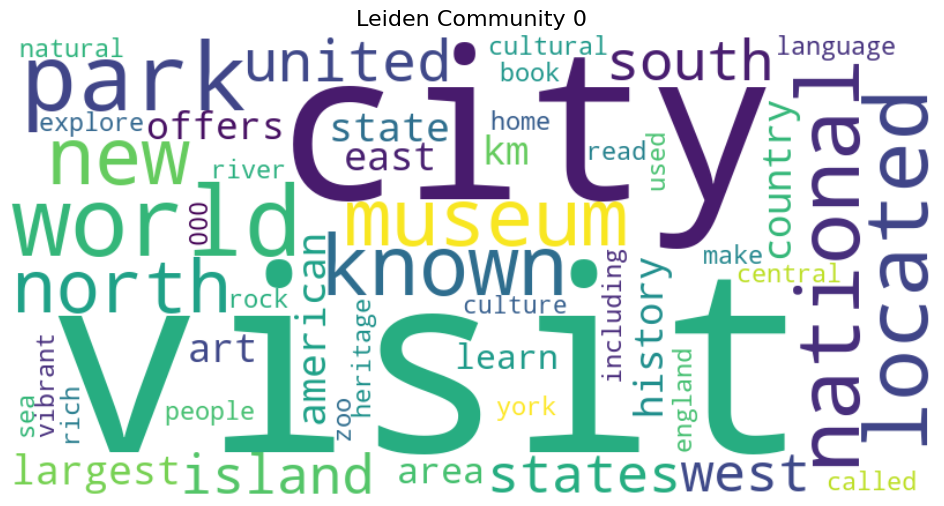

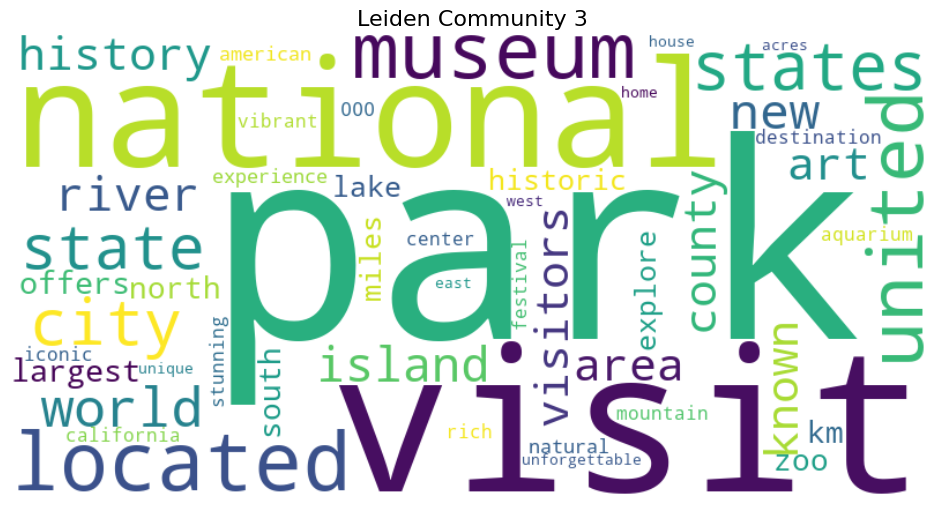

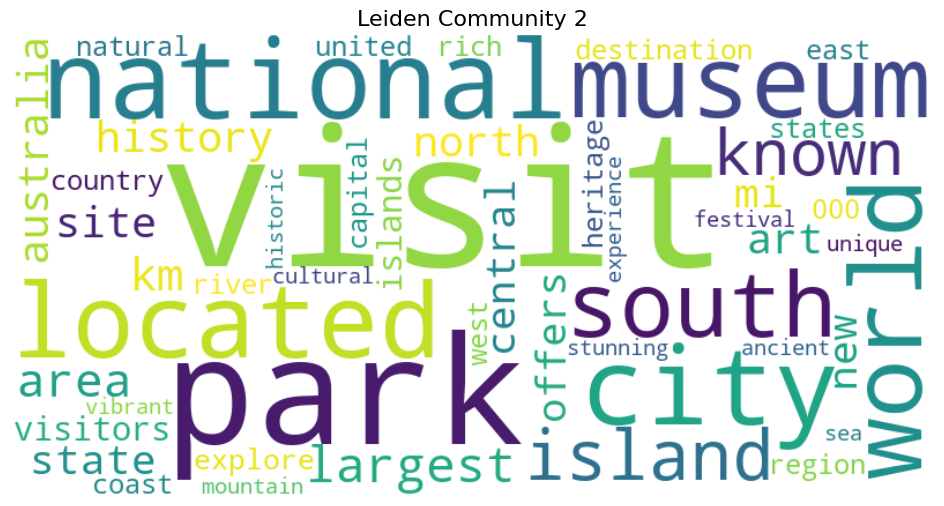

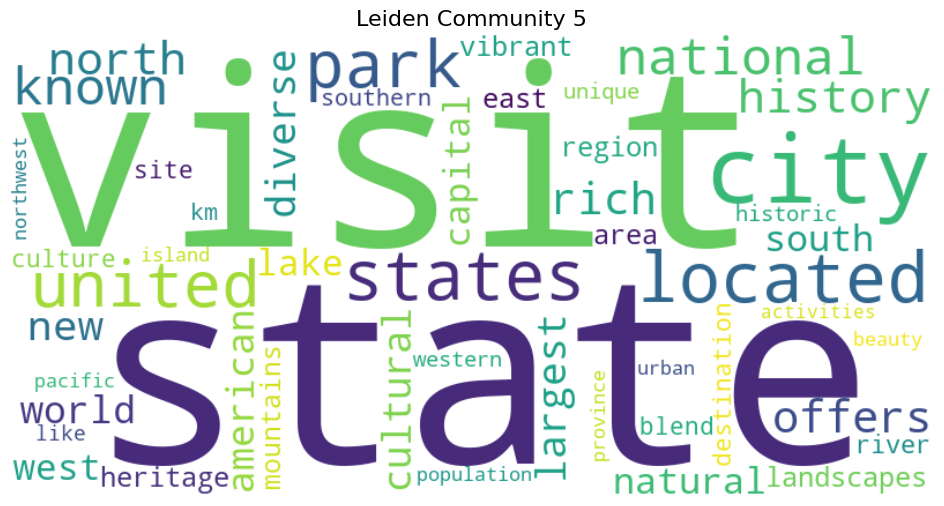

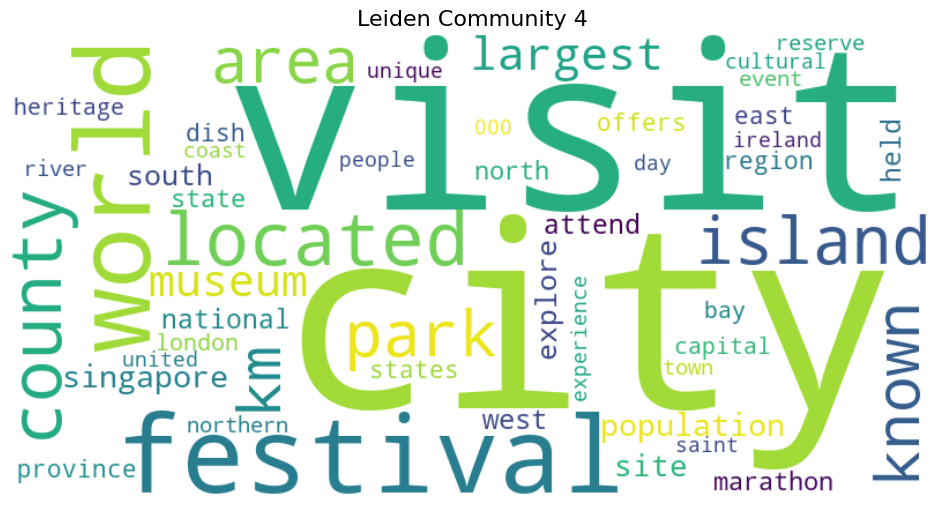

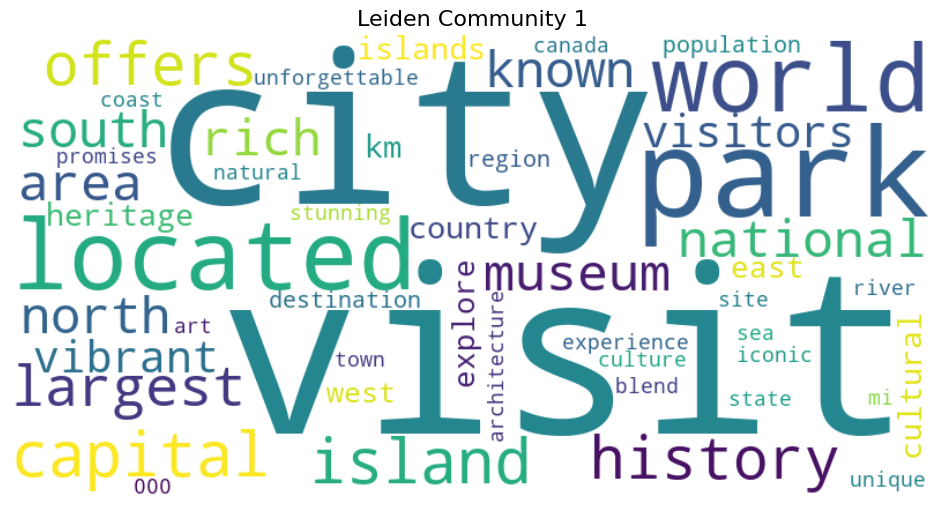

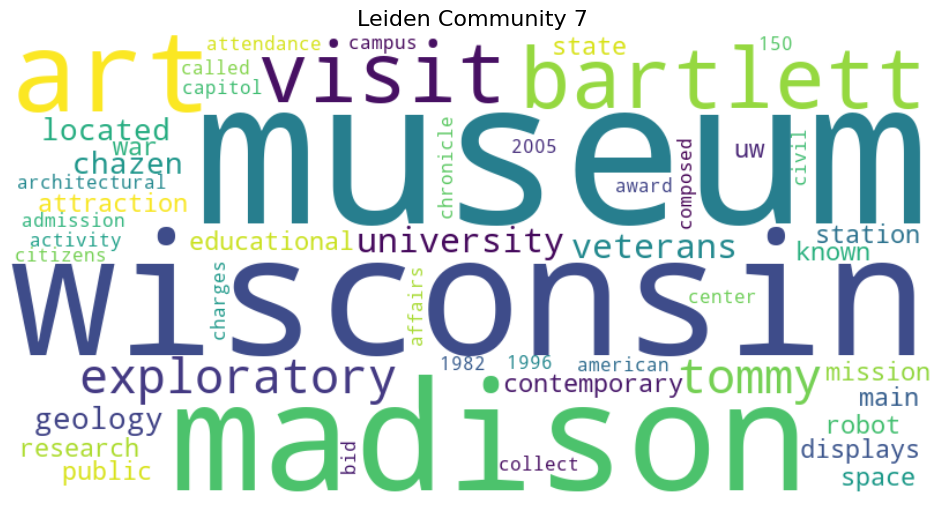

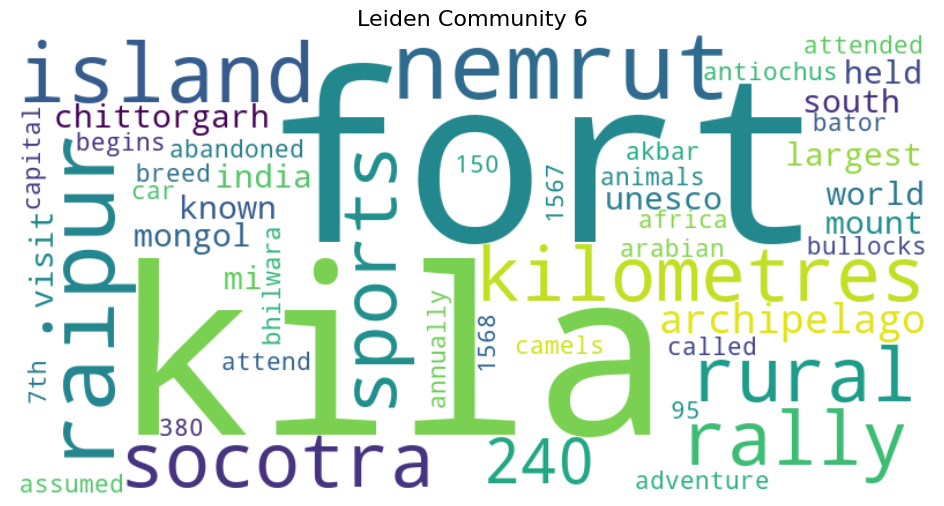

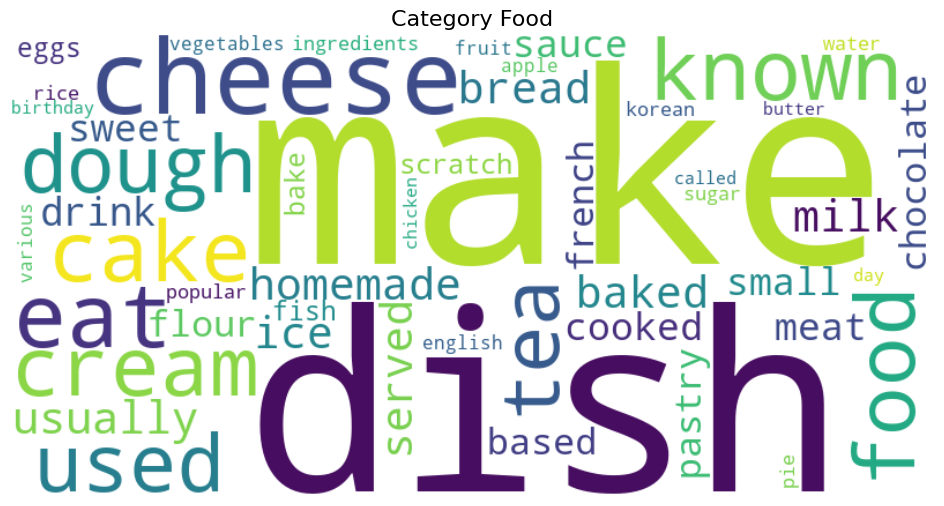

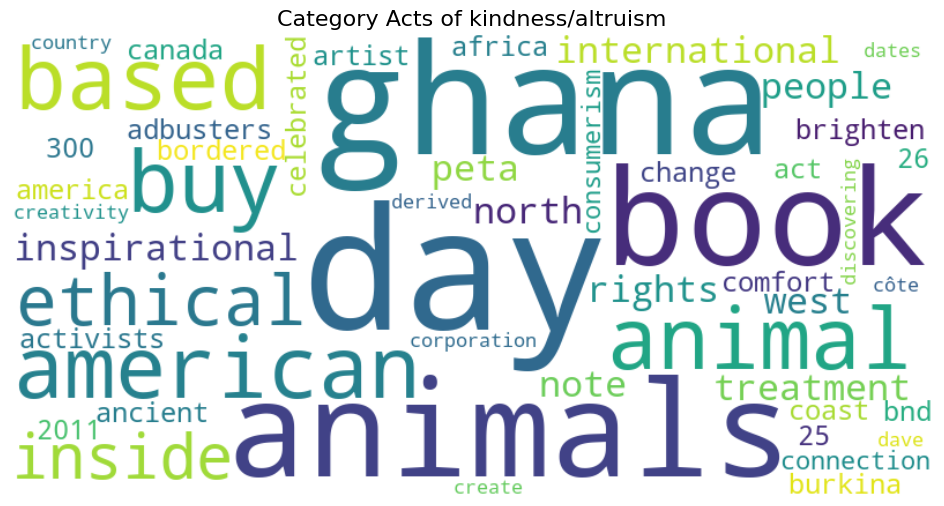

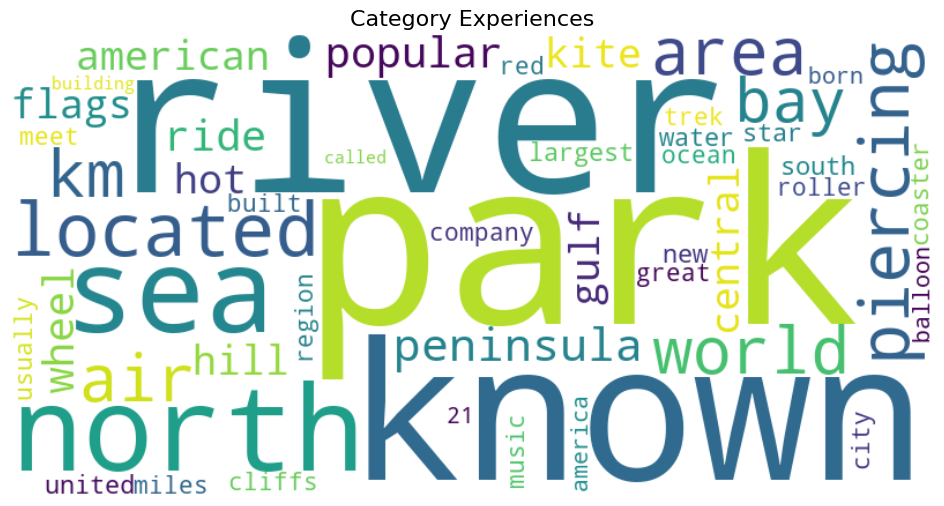

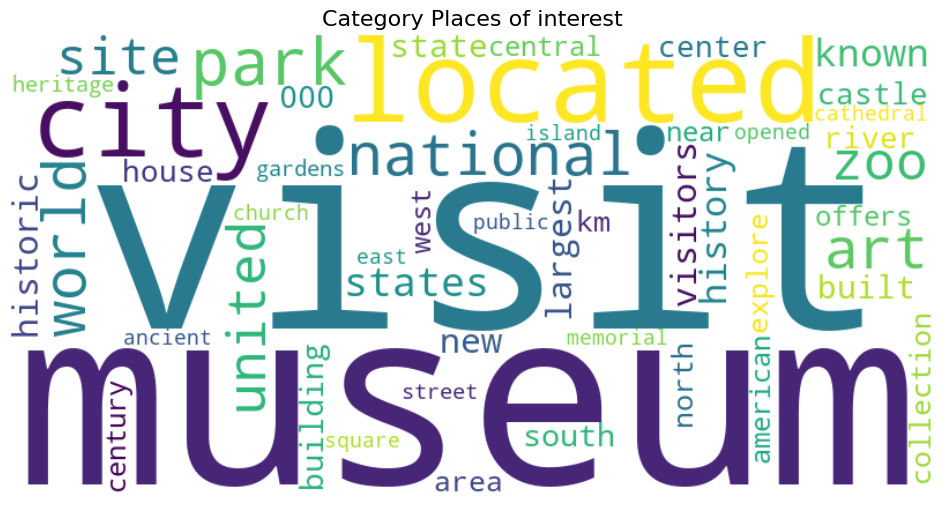

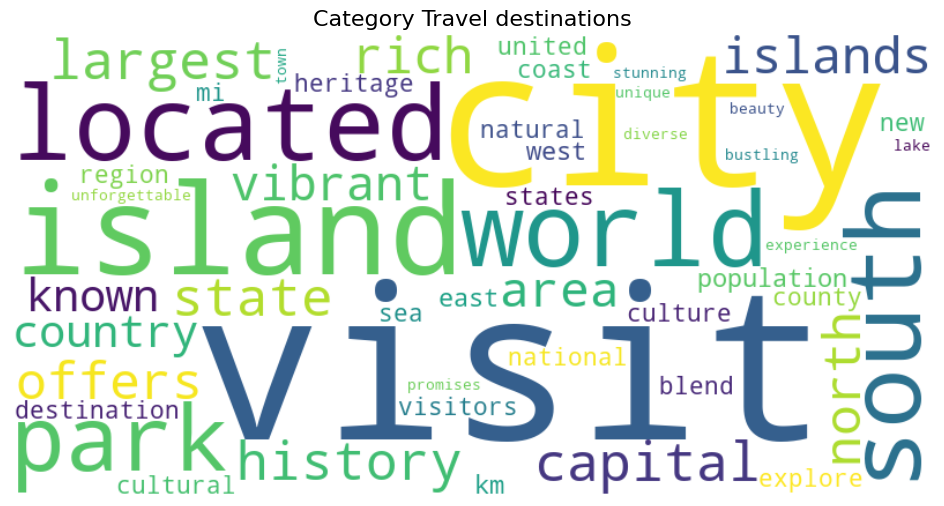

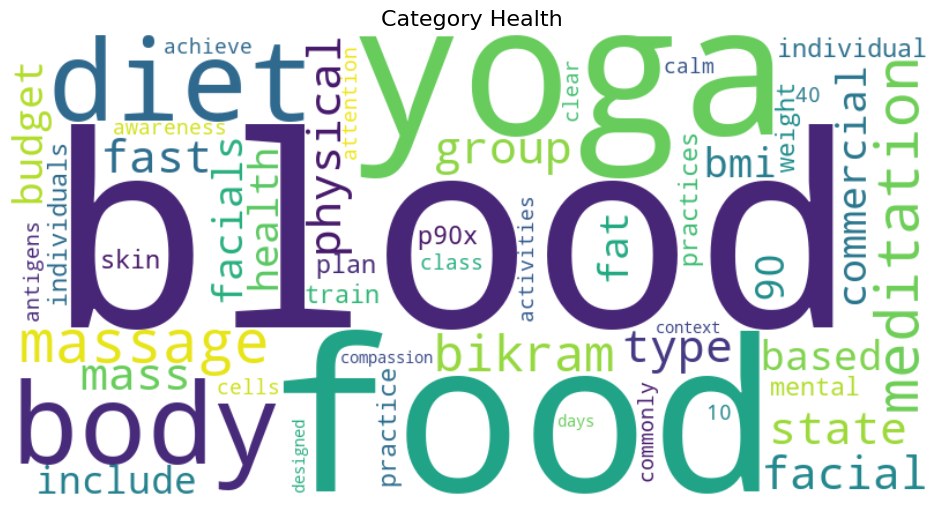

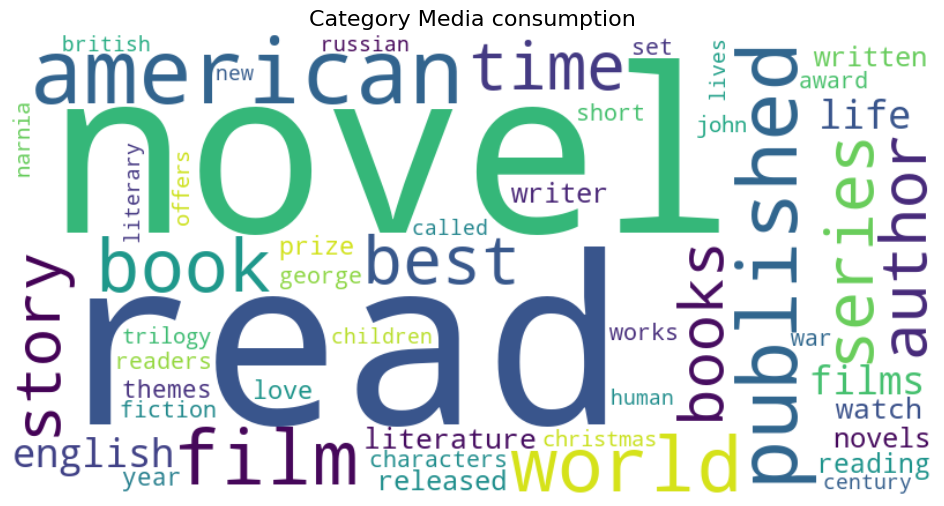

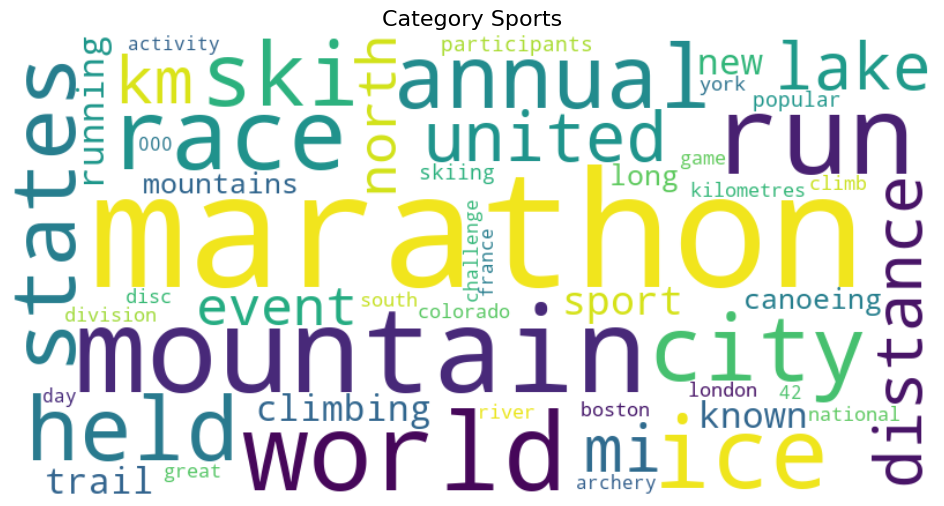

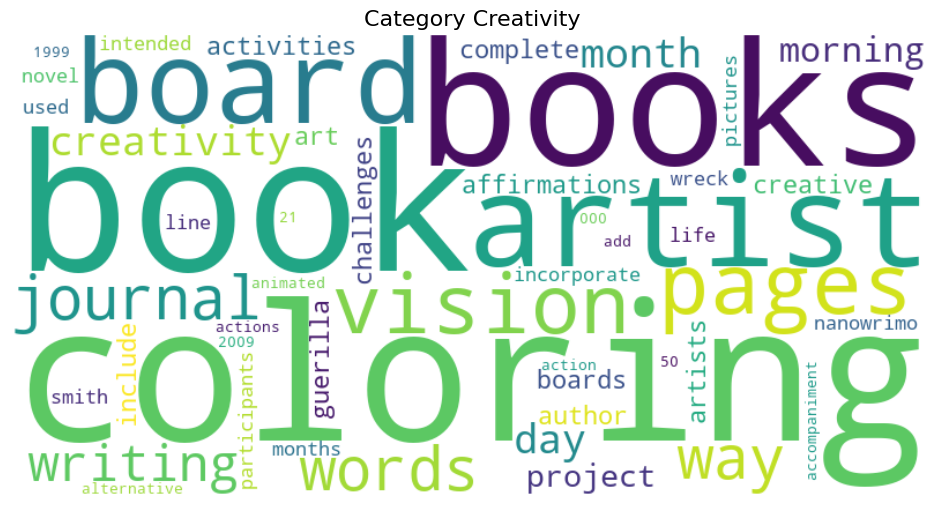

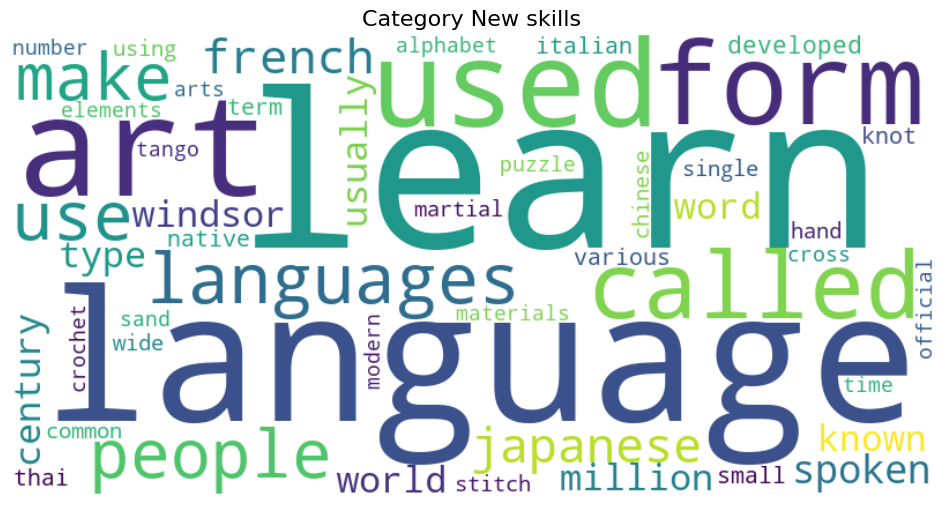

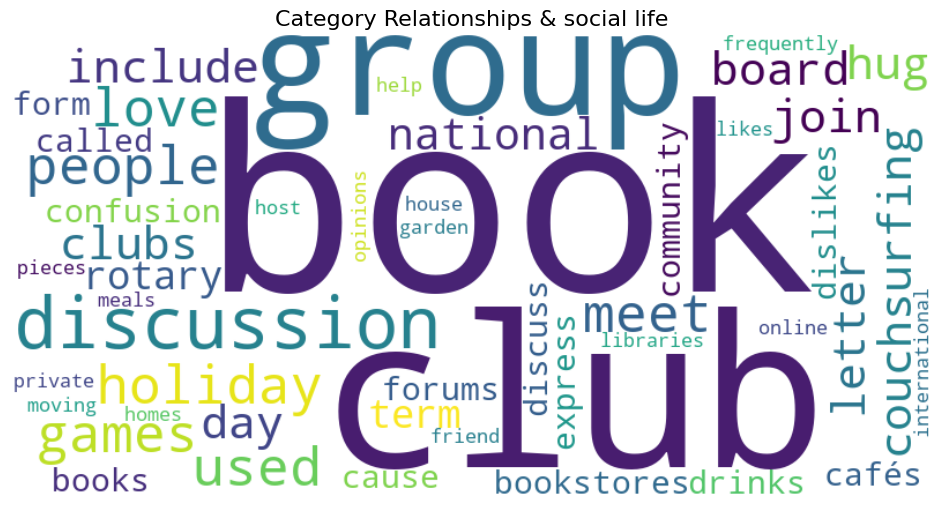

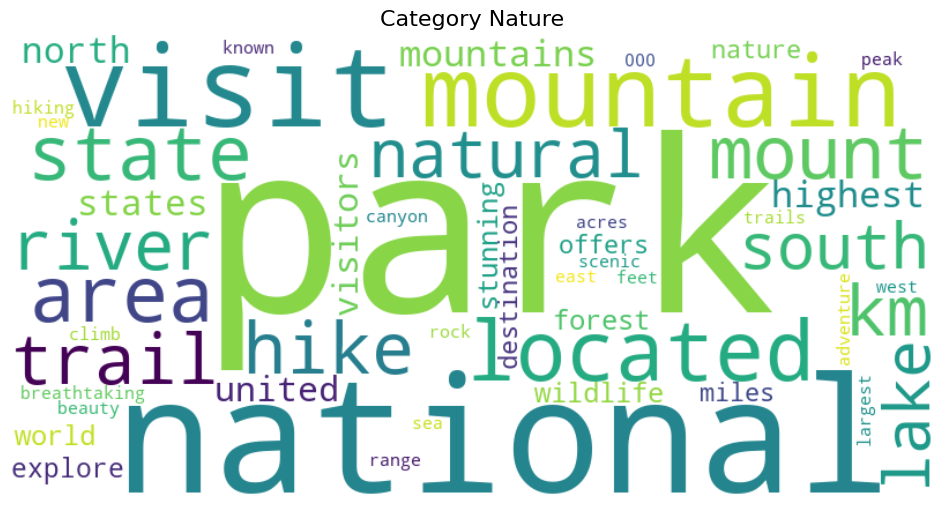

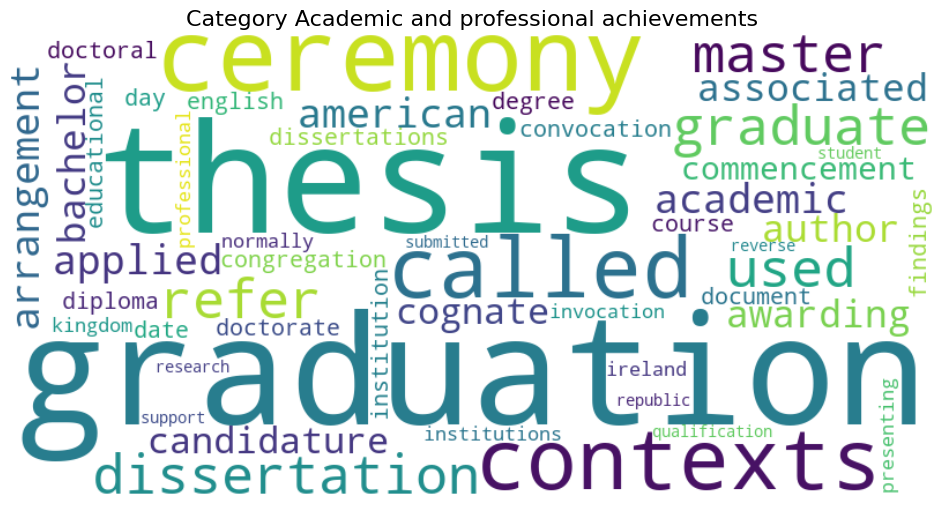

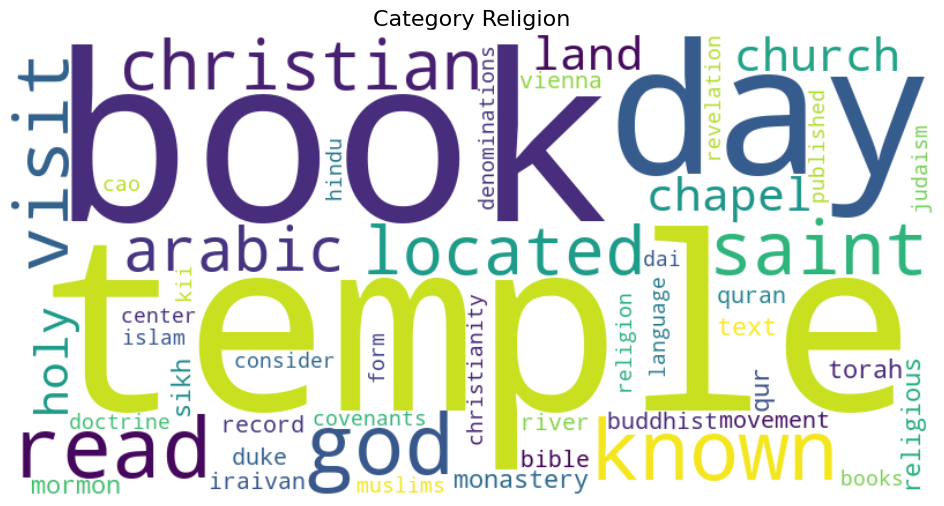

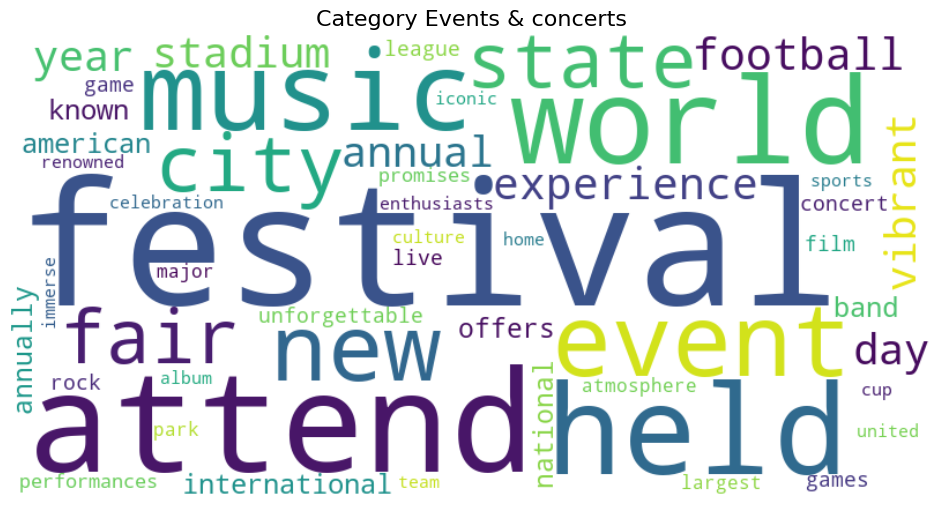

In [32]:
# --- 1. Prepare texts for communities ---
def collect_texts_by_attribute(G, attr_name):
    """Collect texts for each unique attribute in the graph (e.g., category or leiden community)."""
    texts = defaultdict(list)
    for node, data in G.nodes(data=True):
        key = data[attr_name]
        # Concatenate title and description
        text = f"{data.get('title','')} {data.get('description','')}"
        texts[key].append(text)
    # Join all texts per group
    return {k: " ".join(v) for k, v in texts.items()}

# Example: by Leiden community
texts_leiden = collect_texts_by_attribute(Gcc, 'leiden_community')

# Example: by category
texts_category = collect_texts_by_attribute(Gcc, 'category')

# --- 2. TF-IDF + word cloud function ---
def plot_tfidf_wordcloud(texts_dict, max_words=50, title_prefix=""):
    for key, text in texts_dict.items():
        if not text.strip():
            continue
        # Compute TF-IDF
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform([text])
        scores = tfidf_matrix.toarray()[0]
        feature_names = vectorizer.get_feature_names_out()
        # Build dict for WordCloud
        tfidf_dict = dict(zip(feature_names, scores))
        # Plot
        wc = WordCloud(width=800, height=400, background_color='white',
                       max_words=max_words).generate_from_frequencies(tfidf_dict)
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{title_prefix} {key}", fontsize=16)
        plt.show()

# --- 3. Generate word clouds ---
plot_tfidf_wordcloud(texts_leiden, max_words=50, title_prefix="Leiden Community")
plot_tfidf_wordcloud(texts_category, max_words=50, title_prefix="Category")

In the wordclouds for the Leiden communities, we can see that the word 'visit' is almost always included (with the exception of community 6) and also amongst the largest for all communities except 7. The central words in the category based wordclouds are much more diverse and coherent.